# Functions

Load model and data

In [1]:
from collections import OrderedDict
# from scipy import misc
# from imageio import imsave
import torch, cv2
from data.cocostuff_loader import *
from data.vg import *
from model.resnet_generator_v2 import *
from utils.util import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from data.datasets import get_dataset
from torchvision.utils import draw_bounding_boxes
from typing import Union

@dataclass
class MyArgs:
    dataset: str = ''
    model_path: str = ''
    sample_path: str = ''

args = MyArgs()
args.dataset = 'coco'
args.model_path = 'outputs/model/G_65.pth'
args.sample_path = 'samples/test/'

num_classes = 184 if args.dataset == 'coco' else 179
num_o = 8 if args.dataset == 'coco' else 31

dataset = get_dataset('coco', 128, 'val')

idx2name = dataset.vocab['object_idx_to_name']

netG = ResnetGenerator128(num_classes=num_classes, output_dim=3).cuda()

if not os.path.isfile(args.model_path):
    print('Model not found')
    raise FileNotFoundError('Model not found')

state_dict = torch.load(args.model_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`nvidia
    new_state_dict[name] = v

model_dict = netG.state_dict()
pretrained_dict = {k: v for k, v in new_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
netG.load_state_dict(model_dict)

netG.cuda()
netG.eval()

if not os.path.exists(args.sample_path):
    os.makedirs(args.sample_path)
thres=2.0

/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


called set_image_size (128, 128)


Functions

In [2]:
def draw_bboxes(image: torch.Tensor, bbox: Union[torch.Tensor, np.ndarray], labels: torch.Tensor, text=True, color_transform=None, show_idx=False):
    if isinstance(bbox, np.ndarray):
        bbox = torch.from_numpy(bbox)

    colors = None
    label_str = None

    # scale boxes to image size
    # boxes with xmax and ymax
    coord_boxes = scale_boxes(
        bbox, image.shape[-2:], 'coordinates', dtype=torch.int)
    
    if color_transform is not None:
        colors = [(255,255,255) for _ in range(len(labels))]

        # color transformed bboxes in red
        for i in color_transform:
            colors[i] = (255,0,0)
    
    if show_idx:
        label_str = [str(i) for i in range(len(labels))]
    
    if text:
        if show_idx:
            label_str = [label_str[i]+'-'+idx2name[labels[i]] for i in range(len(labels))]
        else:
            label_str = [idx2name[l] for l in labels]

    image = draw_bounding_boxes(image, coord_boxes, labels=label_str, colors=colors)

    return image

In [3]:
def experiment(variable, num_gen=23, max_cols=6, figsize=(20,13), skip=0, transform_bbox=None, transform=None, show_idx=False):

    fakes = []

    # fixed
    if not 'layout' in variable:
        _, label, bbox = dataset[skip]
        bbox = torch.from_numpy(bbox)
        # label, bbox = label.long().unsqueeze(-1).cuda(), torch.from_numpy(bbox)

        layout = torch.zeros(3, 128, 128).type(torch.uint8)
        if transform_bbox is not None:
            layout = draw_bboxes(layout, bbox, label, color_transform=transform_bbox, show_idx=show_idx)
        else: 
            layout = draw_bboxes(layout, bbox, label, show_idx=show_idx)
        
        fakes.append(layout.permute(1,2,0))

    if not 'z_obj' in variable:
        z_obj = torch.from_numpy(truncted_random(num_o=num_o, thres=thres)).float().cuda()
    if not 'z_img' in variable:
        z_im = torch.from_numpy(truncted_random(num_o=1, thres=thres)).view(1, -1).float().cuda()

    # varying
    for idx in range(num_gen):
        if 'layout' in variable:
            _, label, bbox = dataset[skip+idx]
            bbox = torch.from_numpy(bbox)
            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(layout, bbox, label, show_idx=show_idx)
            fakes.append(layout.permute(1,2,0))
        
        bbox_cp = bbox.clone()

        if not transform_bbox is None and idx > 0:
            for box_i in transform_bbox:
                xl, yl, w, h = bbox_cp[box_i]

                if transform is None:
                    bbox_cp[box_i] = torch.tensor([xl+random.uniform(-0.5,0.5), yl+random.uniform(-0.5,0.5), w*random.uniform(0,2), h*random.uniform(0,2)])
                else:
                    bbox_cp = transform(box_i, idx, bbox_cp)
            
            # print(bbox_cp)
            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(layout, bbox_cp, label, color_transform=transform_bbox, show_idx=show_idx)
            fakes.append(layout.permute(1,2,0))

        if 'z_obj' in variable:
            z_obj = torch.from_numpy(truncted_random(num_o=num_o, thres=thres)).float().cuda()
        if 'z_img' in variable:
            z_im = torch.from_numpy(truncted_random(num_o=1, thres=thres)).view(1, -1).float().cuda()

        fake_images = netG.forward(z_obj, bbox_cp.cuda().unsqueeze(0), z_im, label.long().cuda())

        fakes.append(fake_images.detach().squeeze().permute(1,2,0).cpu() * 0.5 + 0.5)

    # print(int(math.ceil((len(fakes))/6)))
    n_rows = int(math.ceil((len(fakes))/6))
    _, axs = plt.subplots(n_rows, max_cols, figsize=figsize)

    for idx, image in enumerate(fakes):
        row = idx // max_cols
        col = idx % max_cols
        # print(f'{row} {col}')
        if n_rows > 1:
            axs[row, col].axis("off")
            axs[row, col].imshow(image, aspect="auto")
        else:
            axs[col].axis("off")
            axs[col].imshow(image, aspect="auto")
    plt.subplots_adjust(wspace=.05, hspace=.05)

In [4]:
layout_index = 29

# Experiments with latents
Fixed layout, everything else varies

/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


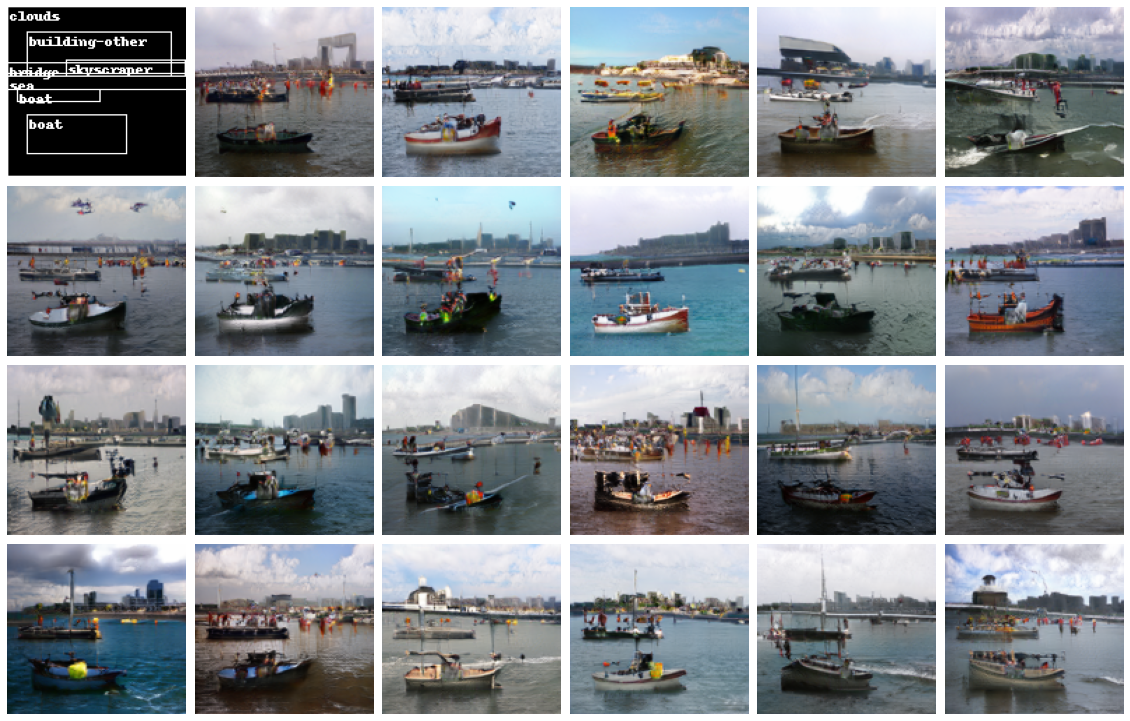

In [5]:
experiment(['z_img', 'z_obj'], skip=layout_index)

Only vary image appearance

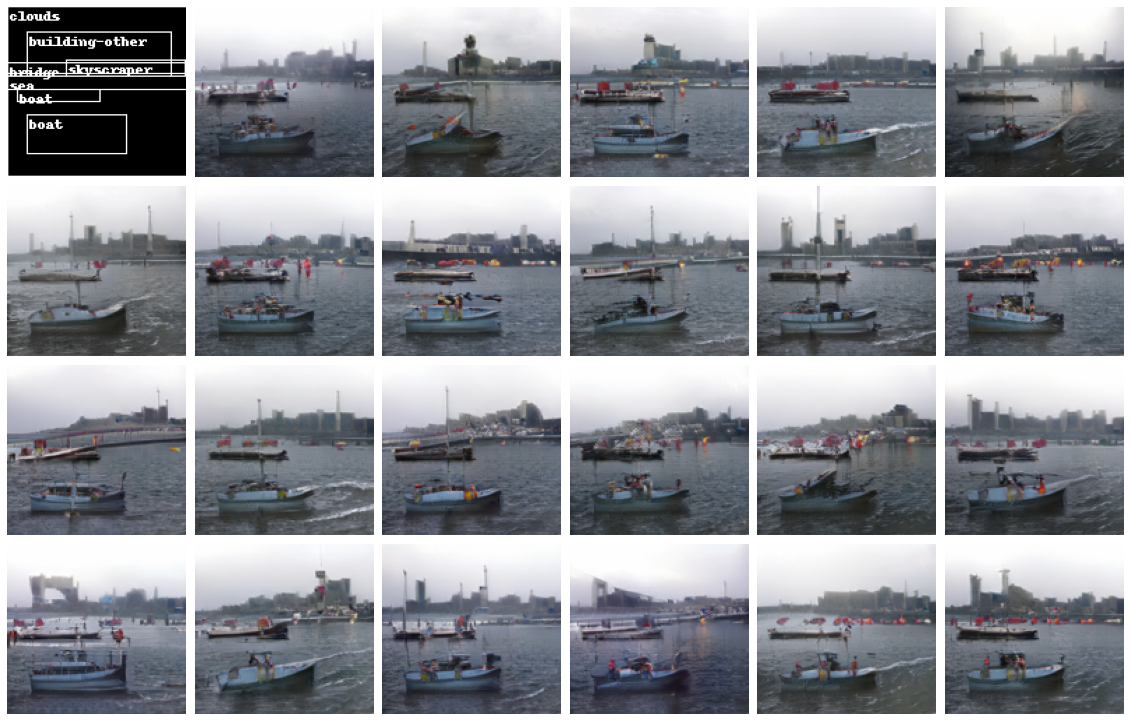

In [6]:
experiment(['z_img'], skip=layout_index)

Vary object appearances

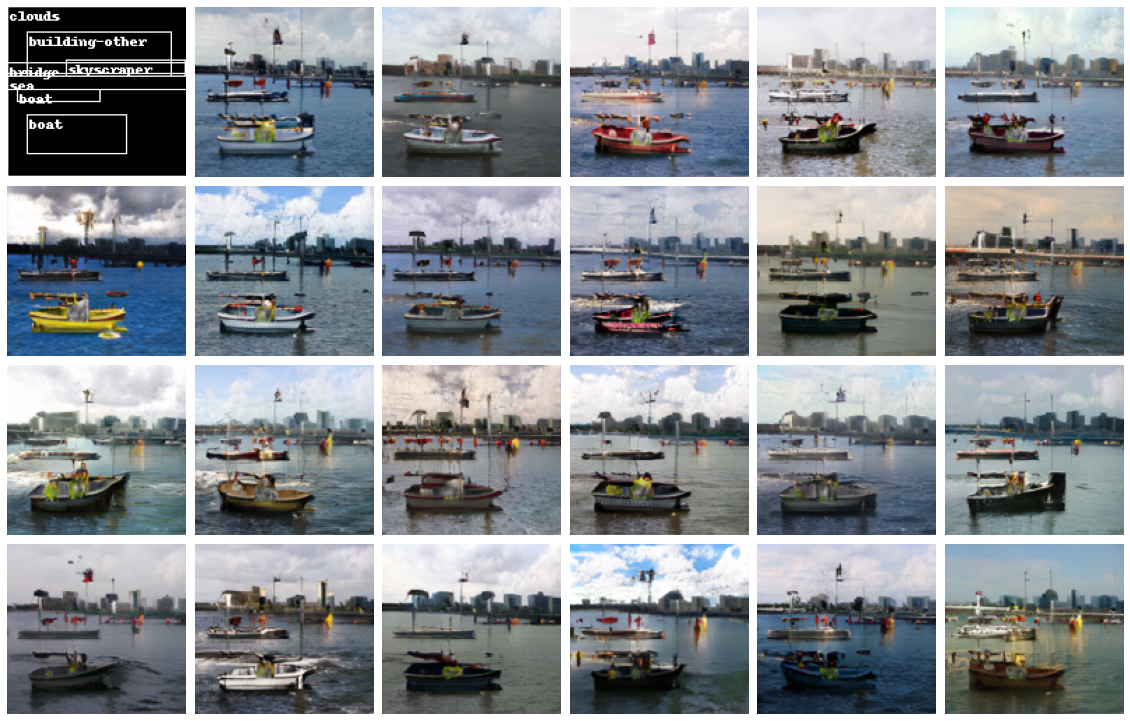

In [7]:
experiment(['z_obj'], skip=layout_index)

Vary layout

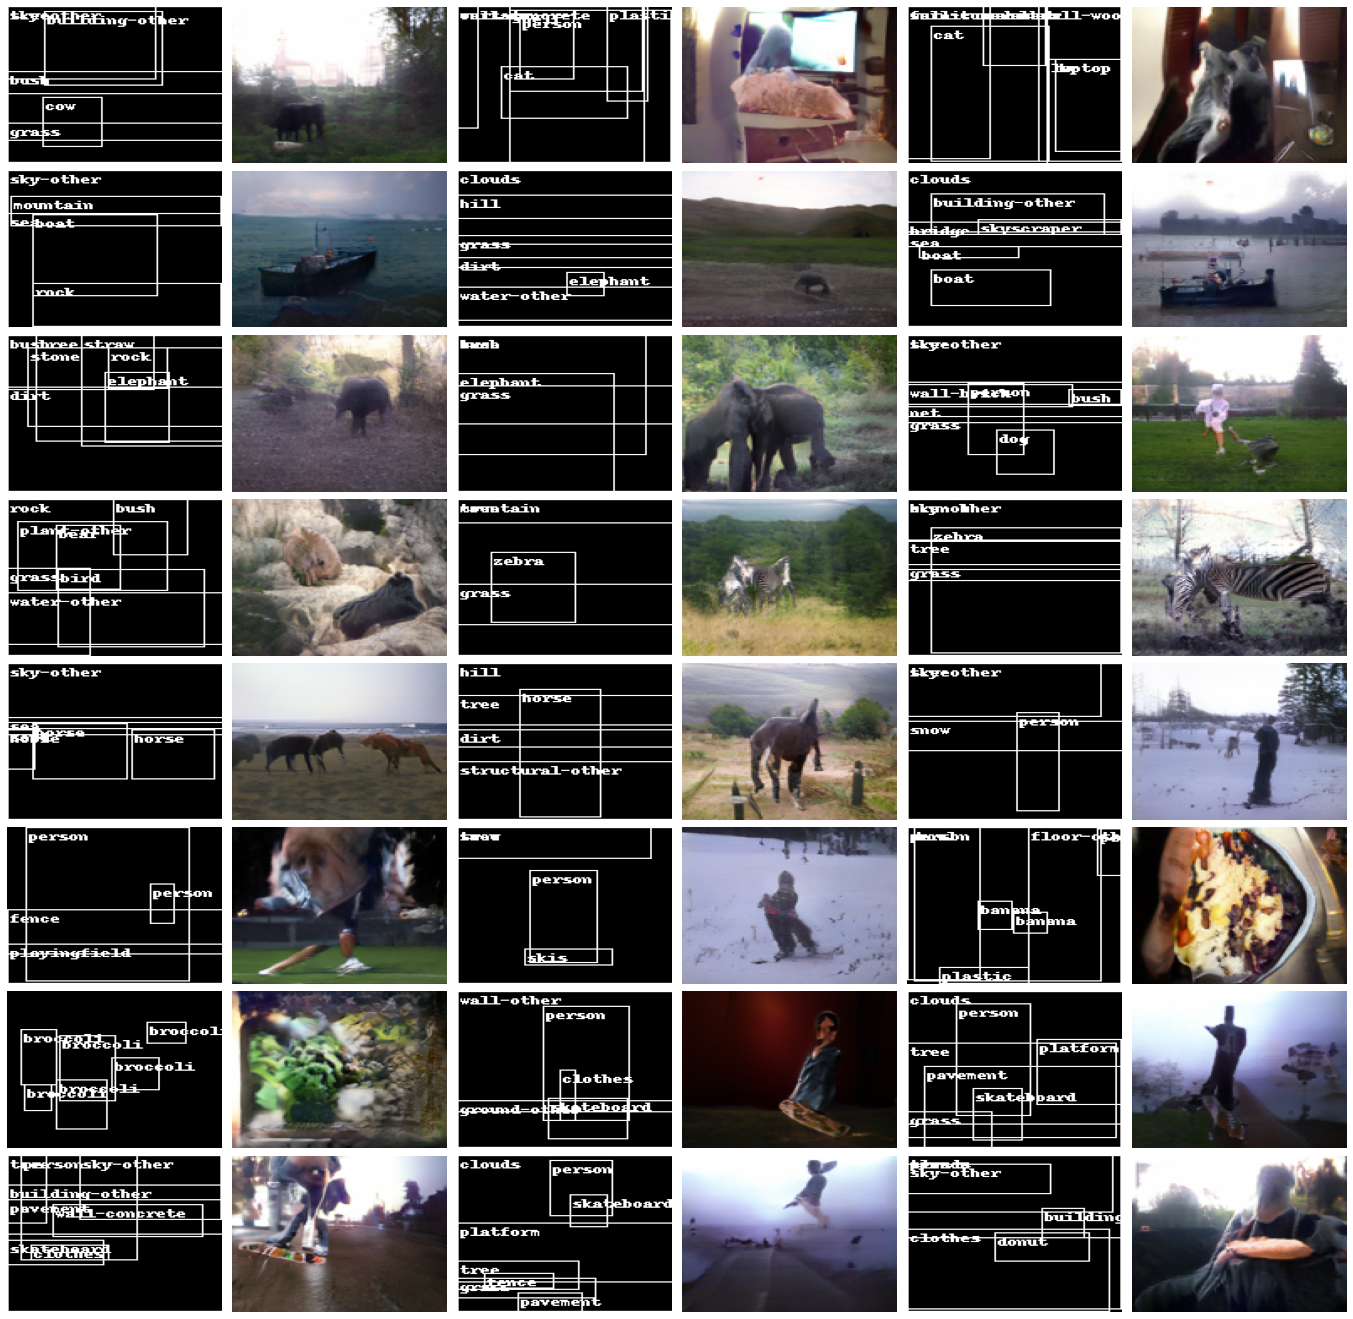

In [8]:
experiment(['layout'], figsize=(24, 24), num_gen=24, skip=24)

In [9]:
# experiment(['layout', 'z_obj'], figsize=(24,24), num_gen=24)

# Experiments with bounding boxes
Transform bounding boxes

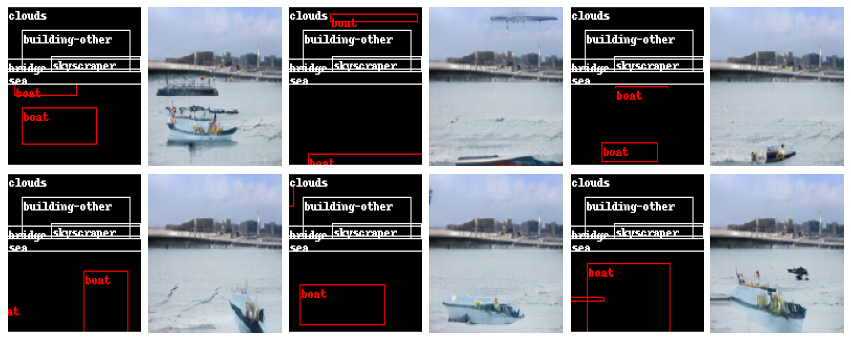

In [10]:
experiment([], figsize=(15, 6), num_gen=6, skip=layout_index, transform_bbox=[0,1])

Remove bboxes by moving them outside of the scene and making them very small

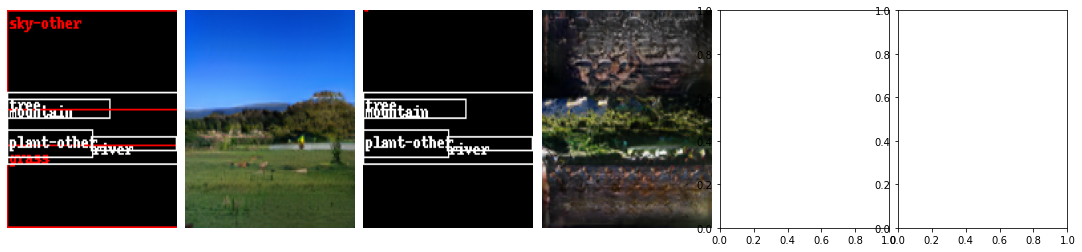

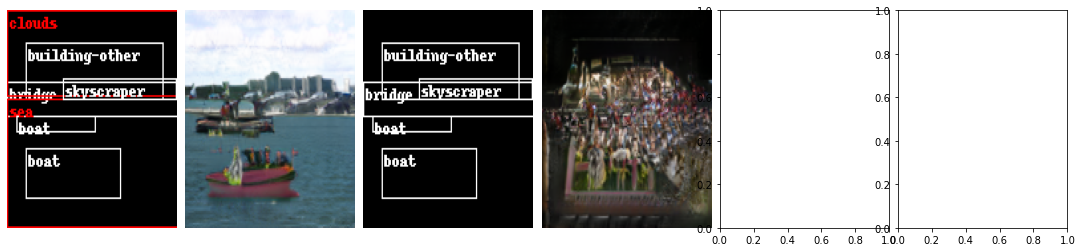

In [11]:
def remove_bbox(box_i, idx, bbox):
    bbox[box_i] = torch.tensor([-0.1,-0.1,0.0001,0.0001])
    return bbox

# 29
# 4 clouds, 5 sea
# 0, 1 boats
# 23
# 4 sky-other
# 0 grass
experiment([], figsize=(19, 4), num_gen=2, skip=23, transform_bbox=[4,0], transform=remove_bbox)
experiment([], figsize=(19, 4), num_gen=2, skip=29, transform_bbox=[4,5], transform=remove_bbox)

# Experiments with videos

In [12]:
def experiment_video(num_gen=23, max_cols=6, figsize=(20,13), skip=0, transform_bbox=None, transform=None, pixels=1, vid_name=None, max_plot=None):

    fakes = []

    z_obj = torch.from_numpy(truncted_random(num_o=num_o, thres=thres)).float().cuda()
    z_im = torch.from_numpy(truncted_random(num_o=1, thres=thres)).view(1, -1).float().cuda()

    for idx in range(num_gen):

        if idx == 0:
            _, label, bbox = dataset[skip]
            bbox = torch.from_numpy(bbox)
            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(layout, bbox, label)
            fakes.append(layout.permute(1,2,0))
            bbox_cp = bbox.clone()
        

        if not transform_bbox is None and idx > 0:
            for box_i in transform_bbox:
                xl, yl, w, h = bbox_cp[box_i]

                
                if transform is None:
                    # slightly move to the right
                    bbox_cp[box_i] = torch.tensor([xl+pixels*(1/128), yl, w, h])
                else:
                    bbox_cp = transform(box_i, idx, pixels, bbox_cp)

        fake_images = netG.forward(z_obj, bbox_cp.cuda().unsqueeze(0), z_im, label.long().cuda())

        fakes.append(fake_images.detach().squeeze().permute(1,2,0).cpu() * 0.5 + 0.5)

    
    h, w, c = fakes[1].shape
    filename = f'samples/vids/{vid_name}_{skip}.avi'

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    writer = cv2.VideoWriter(filename, fourcc, 10, (w, h))

    for frame in fakes[1:]:
        # normalize image to be converted to uint8
        frame = cv2.normalize(src=frame.numpy(), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        writer.write(frame)
    
    writer.release()


    if max_plot is None:
        end_for = enumerate(fakes)
        n_rows = int(math.ceil((len(fakes))/6))
    else:
        end_for = enumerate(fakes[:max_plot])
        n_rows = int(math.ceil(max_plot / 6))

    _, axs = plt.subplots(n_rows, max_cols, figsize=figsize)

    for idx, image in end_for:
        row = idx // max_cols
        col = idx % max_cols
        # print(f'{row} {col}')
        if n_rows > 1:
            axs[row, col].axis("off")
            axs[row, col].imshow(image, aspect="auto")
        else:
            axs[col].axis("off")
            axs[col].imshow(image, aspect="auto")
    plt.subplots_adjust(wspace=.05, hspace=.05)

Moving objects

Random image: 5642


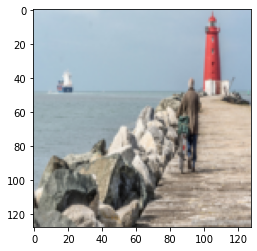

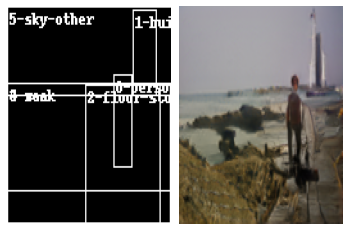

In [13]:
random_idx = int(np.ceil(np.random.random()*len(dataset)))
print(f'Random image: {random_idx}')

real, _, _ = dataset[random_idx]
plt.imshow(real.permute(1,2,0)*0.5+0.5)
experiment([], 1, 2, figsize=(6, 4), skip=random_idx, show_idx=True)

In [ ]:
def move_down(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl, yl+pixels*(1/128), w, h])
    return bbox

def move_up(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl, yl-pixels*(1/128), w, h])
    return bbox

def move_left(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl-pixels*(1/128), yl, w, h])
    return bbox

# bus
# experiment_video(figsize=(15, 10), num_gen=59, skip=12, transform_bbox=[0], vid_name='coco_bus', max_plot=24)
# person swimming
# experiment_video(figsize=(15, 10), num_gen=59, skip=59, transform_bbox=[0], transform=move_down, vid_name='coco_swim_down', max_plot=24)

# boat
# experiment_video(figsize=(15, 10), num_gen=59, skip=layout_index, transform_bbox=[1], transform=move_down, vid_name='coco_boat_down', max_plot=24)
# trucks, 0 1
# experiment_video(figsize=(15, 10), num_gen=59, skip=4547, transform_bbox=[0], transform=move_left, vid_name='coco_truck', max_plot=24)
# players, 0 1 players
# experiment_video(figsize=(15, 10), num_gen=59, skip=1464, transform_bbox=[1], transform=move_left, vid_name='coco_pl', max_plot=24)
# giraffes
# experiment_video(figsize=(15, 10), num_gen=120, skip=4063, transform_bbox=[1], transform=move_left, vid_name='coco_giraffe2', max_plot=24)
# bears (simple), 0 1
# experiment_video(figsize=(15, 10), num_gen=120, skip=6098, transform_bbox=[0], transform=move_up, vid_name='coco_bear_small', max_plot=24)
# experiment_video(figsize=(15, 10), num_gen=120, skip=6098, transform_bbox=[1], transform=move_up, vid_name='coco_bear', max_plot=24)
# car
# experiment_video(figsize=(15, 10), num_gen=120, skip=5103, transform_bbox=[0], transform=move_up, vid_name='coco_car', max_plot=24)
# cow
# experiment_video(figsize=(15, 10), num_gen=120, skip=5641, transform_bbox=[1], transform=move_left, vid_name='coco_cow', max_plot=24)